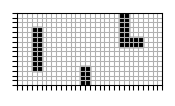

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from customizedShape import CustomizedShape

# Fixing random state for reproducibility
np.random.seed(19680801)


# Create new Figure and an Axes which fills it.
fig = plt.figure(num="besiege", figsize=(10, 10), dpi=96, facecolor='w', edgecolor='k')
ax = fig.add_subplot(1, 1, 1)



# Environment setup parameters -- Customized paramaters.
env_width = 30
env_height = 15
n_robot = 20
n_target = 1

# Environment robots setup.
# Deploy robots.
data_robot = np.zeros(n_robot, dtype=[('position', float, 2),
                                      ('color',    float, 4)])
# Deploy targets.
data_target = np.zeros(n_target, dtype=[('position', float, 2),
                                        ('color',    float, 4)])
# Deploy walls.
for shape in CustomizedShape().walls['shape']:
    ax.add_patch(shape)
# print(CustomizedShape().walls['position'])



# Construct the scatter which we will update during animation
# as time progess.
scatter_robot = ax.scatter(data_robot['position'][:, 0], data_robot['position'][:, 1],
                           s=256, lw=0.5, 
                           edgecolors=data_robot['color'], facecolors=data_robot['color'], 
                           marker=CustomizedShape().marker_robot)
scatter_target = ax.scatter(data_target['position'][:, 0], data_target['position'][:, 1],
                            s=256, lw=0.5, 
                            edgecolors=data_target['color'], facecolors=data_target['color'], 
                            marker=CustomizedShape().marker_target)

    
    
    
#
def init():
    
    # Environment Backgroud setup.
    x_ticks = np.arange(0, env_width + 1, 1)
    y_ticks = np.arange(0, env_height + 1, 1)
    ax.set_xlim(0, env_width)
    ax.set_ylim(0, env_height)
    ax.set_aspect('equal')
    ax.set_xticks(x_ticks)
    ax.set_yticks(y_ticks)
    ax.grid(True)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
    # Initialize data.
    data_robot['position'] = np.random.uniform([0, 0], [env_width, env_height], (n_robot, 2))
    data_target['position'][0] = np.asarray([[round(env_width*0.5) + 0.5, round(env_height*0.5) + 0.5]])
    

    
#
def data_gen(frame_number=0):
    
    threshold = 1e2
    step_x = 0.
    step_y = 0.
    
    while frame_number < threshold:
        # Get an index which we can use to re-spawn the oldest data.
        current_index_robot = frame_number % n_robot 

        # Make all colors more transparent as time progresses.
        # robot.
#         data_robot['color'][:, 3] -=  1.0/len(data_robot)
#         data_robot['color'][:, 3] = np.clip(data_robot['color'][:, 3], 0, 1)
        data_robot['color'][current_index_robot] = (0, 1, 0, 1)
        # target.
        data_target['color'][0] = (1, 0, 0, 1)

        # Pick a new position for oldest data.
        # robot.
        data_robot['position'][current_index_robot] = np.random.uniform([0+step_x, 0+step_y], [env_width-step_x, env_height-step_y], 2)
        # target.
        data_target['position'][0] = np.asarray([[round(env_width*0.5) + 0.5, round(env_height*0.5) + 0.5]])
        # wall.
        

        # Update.
        frame_number += 1
        step_x += (env_width / 2 - 2) / (threshold)
        step_y += (env_height/ 2 - 2) / (threshold)
        
        yield data_robot, data_target
    


def update(data):
    
    # Update the scatter collection, with the new colors and positions.
    # Update robots.
    scatter_robot.set_edgecolors(data_robot['color'])
    scatter_robot.set_facecolors(data_robot['color'])
    scatter_robot.set_offsets(data_robot['position'])
    # Update targets.
    scatter_target.set_edgecolors(data_target['color'])
    scatter_target.set_facecolors(data_target['color'])
    scatter_target.set_offsets(data_target['position'])
    


# Construct the animation, using the update function as the animation director.
animation = animation.FuncAnimation(fig, update, data_gen, interval=5, init_func=init,
                                   repeat=False)
plt.show()